# Brain Tumor Detection & Classification via Deep Transfer Learning

## Introduction

### Medical Context
Brain tumors represent one of the most complex and critical medical conditions, where early and accurate diagnosis is crucial to a patient's life expectancy. Magnetic Resonance Imaging (MRI) is the standard imaging technique for diagnosis; however, manual analysis of these scans is time-consuming and subject to interpretive variability among radiologist experts.

In this project, we explore the application of Deep Learning, and specifically Transfer Learning techniques, to automate two crucial tasks:

* 1. **Detection**: Distinguishing a healthy brain (`notumor`) from one affected by pathology.

* 2. **Classification**: Identifying the specific tumor type among three of the most common variants: Glioma, Meningioma, and Pituitary Tumor.



### Dataset

The dataset used is the [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) (source: Kaggle). It consists of MRI images organized into two main sets (Training and Testing), divided into four balanced classes.

The sample distribution is as follows:

| Class | Description | Target Set | Training Set |
| :----- | :--------: | :--------: | -----------: |
| `glioma` | Tumor arising from glial cells. | 1321 | 300 |
| `meningioma` | Tumor arising from the meninges. | 1339 | 306 |
| `pituitary` | Tumor of the pituitary gland (hypophysis). |1457 |300|
| `notumor` | Control scans (healthy subjects). | 1595 | 405 |
| **Total** | | 5712 | 1311|

### Objective
The primary diagnostic objective is to minimize **False Negatives**. Specifically, the `notumor` class represents our north star: it is imperative that the model recognizes healthy patients with the utmost accuracy, without missing a single pathological case.

Preliminary results on the test set show excellent metrics, with an **Overall Accuracy** of $99\%$. Of particular note is the performance on the `notumor` class, which achieved a **Recall and Precision of $100\%$**, indicating the model's perfect ability to distinguish healthy subjects from those with cancer, reducing the risk of false alarms or missed diagnoses to zero for this critical class.

# Development

## 1. Environment Setup & Data Loading

### Dataset Download

Download the dataset from Kaggle

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 1.71GB/s]


In [4]:
!unzip -q brain-tumor-mri-dataset.zip -d brain_tumor_dataset

### Libraries

We load all the libraries needed for the analysis

In [5]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------------

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ----------------------------------

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import Xception
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.data import Dataset, AUTOTUNE

### Dataset Definition

The dataset is already separated into `Training` and `Testing` directories. We will later divide the latter into `Test` and `Validation`. Let's define the paths of the two directories.

In [6]:
train_dir = 'brain_tumor_dataset/Training'
test_dir  = 'brain_tumor_dataset/Testing'

The `Training` and `Testing` directories are composed of $4$ folders: `glioma`, `meningioma`, `pituitary`, and `notumor`; within these folders are the related images. We associate the names of these subdirectories with the classes

In [7]:
if os.listdir(train_dir) == os.listdir(train_dir):
  tumor_class = os.listdir(train_dir)

Let's now create a list of image paths for training and testing with the relative class they belong to.

In [8]:
train = []
test = []

for class_name in tumor_class:
  for image_file in os.listdir(os.path.join(train_dir, class_name)):
    train.append([train_dir + '/' + class_name + '/' + image_file, class_name])
  for image_file in os.listdir(os.path.join(test_dir, class_name)):
    test.append([test_dir + '/' + class_name + '/' + image_file, class_name])

I transform the lists into pandas `DataFrame`, to better do the EDA, and I give a shuffle

In [9]:
df_train = pd.DataFrame(train, columns=['path', 'class'])
df_train = df_train.sample(frac=1).reset_index(drop=True)

df_test = pd.DataFrame(test, columns=['path', 'class'])
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [10]:
df_train.head()

,path,class
0,brain_tumor_dataset/Training/glioma/Tr-gl_0413...,glioma
1,brain_tumor_dataset/Training/glioma/Tr-gl_1130...,glioma
2,brain_tumor_dataset/Training/glioma/Tr-gl_1203...,glioma
3,brain_tumor_dataset/Training/glioma/Tr-gl_0982...,glioma
4,brain_tumor_dataset/Training/notumor/Tr-no_146...,notumor


## 2. Exploratory Data Analysis

Let's visualize the distribution of classes in the two data frames

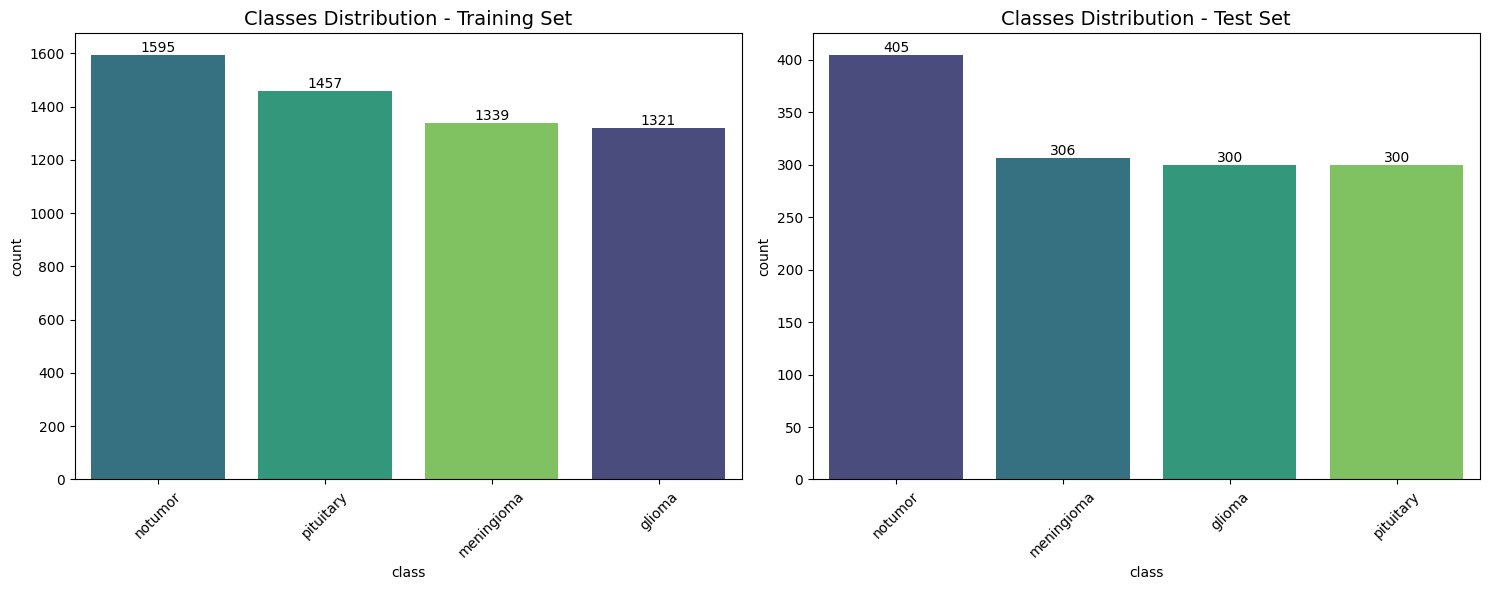

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(x='class', data=df_train, ax=axes[0], palette='viridis', hue='class', legend=False, order=df_train['class'].value_counts().index)
axes[0].set_title('Classes Distribution - Training Set', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
for container in axes[0].containers:
    axes[0].bar_label(container)

sns.countplot(x='class', data=df_test, ax=axes[1], palette='viridis', hue='class', legend=False ,order=df_test['class'].value_counts().index)
axes[1].set_title('Classes Distribution - Test Set', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
for container in axes[1].containers:
    axes[1].bar_label(container)

plt.tight_layout()
plt.show();

Both datasets are essentially balanced and do not require complex correction techniques such as SMOTE or Class Weights.

Let's look at some images in the training dataset.

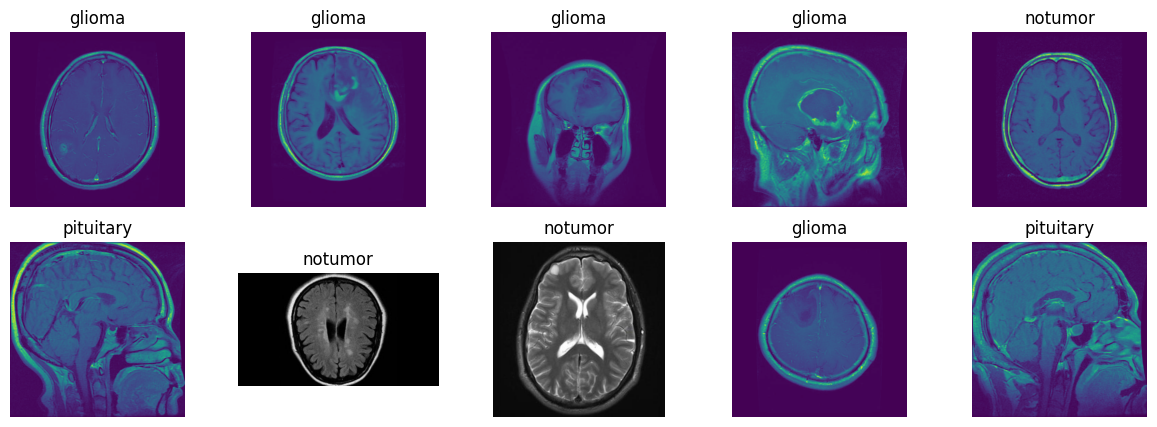

In [12]:
plt.figure(figsize=(15, 5))

for i in range(10):
  ax = plt.subplot(2, 5, i + 1)
  plt.title(df_train['class'][i])
  plt.axis("off")
  plt.imshow(plt.imread(df_train['path'][i]))

The images reveal heterogeneity in file format: some scans are saved in grayscale ($1$ channel), while others are already in RGB format ($3$ channels).

Since the *Xception* architecture was pre-trained on the *ImageNet* dataset and requires an input tensor with a depth of $3$, it will be necessary to standardize the entire dataset during preprocessing. We will force all images to be decoded in RGB format (replicating the gray channel where necessary), thus ensuring dimensional compatibility with the first layer of the neural network.

## 3. Data Preprocessing & Pipeline Construction

For label management, we opted for **One-Hot Encoding** (combined with the `categorical_crossentropy` loss) rather than sparse encoding (`sparse_categorical_crossentropy`).

Although theoretically equivalent, during the testing phase, the One-Hot approach ensured **greater stability in gradient calculations** and full dimensional compatibility with complex evaluation metrics (such as per-class Precision and Recall) and with the model architecture, avoiding ambiguities in the rank of the output tensors.

In [16]:
one_hot_train = pd.get_dummies(df_train['class'], dtype=int)
one_hot_test = pd.get_dummies(df_test['class'], dtype=int)

df_train = pd.concat([df_train, one_hot_train], axis=1)
df_test = pd.concat([df_test, one_hot_test], axis=1)

df_train = df_train.drop('class', axis=1)
df_test = df_test.drop('class', axis=1)

In [17]:
df_train.columns

Index(['path', 'glioma', 'meningioma', 'notumor', 'pituitary'], dtype='object')

To monitor the performance of the model during training and avoid the overfitting phenomenon, we obtain the validation dataset (the $10\%$) from the training dataset.

In [19]:
df_train, df_val = train_test_split(df_train,
                                   test_size=0.1,
                                   random_state=42,
                                   stratify = df_train[['glioma', 'meningioma', 'notumor', 'pituitary']].values)

Before processing the images, we convert our data (file paths and labels) into `tf.data.Dataset` objects.

We use the `.from_tensor_slices()` method, which acts like a generator: instead of loading all the thousands of images into RAM instantly (which would crash the system), it creates a stream of (file_path, labels) pairs. The images will actually be loaded only in the next step, on demand.

In [20]:
train_list_ds = Dataset.from_tensor_slices((df_train['path'].values,
                                            df_train[['glioma', 'meningioma', 'notumor', 'pituitary']].values))
val_list_ds   = Dataset.from_tensor_slices((df_val['path'].values,
                                            df_val[['glioma', 'meningioma', 'notumor', 'pituitary']].values))
test_list_ds  = Dataset.from_tensor_slices((df_test['path'].values,
                                            df_test[['glioma', 'meningioma', 'notumor', 'pituitary']].values))

As mentioned, it's necessary to define a preprocessing function (`process_image`) that transforms the file paths into neural network-ready tensors. The operations performed are:
* **Decoding**: Converting the `path` string into the corresponding pixel matrix (loading the image).
* **Channel Uniformity**: Forced stretching to 3 channels (RGB), a fundamental requirement for the pre-trained Xception model.
* **Conservative Scaling**: Scaling to $224 \times 224$ using the Padding technique. This avoids cropping or warping the content, preserving the original height-to-width ratio.
* **Normalization**: Scaling pixel values ​​from the integer range $[0, 255]$ to the decimal range $[0, 1]$ to aid model convergence.

In [26]:
def process_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize_with_pad(image, 224, 224)
    image /= 255.0
    return image, label

Now we apply the `process_image()` function to the entire dataset using the `.map()` method.

Next, we organize the data into Batches. Instead of feeding the neural network a single image at a time, we create fixed-size packets ($N=16$). This allows us to take advantage of GPU parallel processing.

In [27]:
train_ds = train_list_ds.map(process_image)
val_ds = val_list_ds.map(process_image)
test_ds = test_list_ds.map(process_image)

BATCH_SIZE = 16

train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

Let's do a quick check to verify the correctness of the final dimensions

In [28]:
image_batch, label_batch = next(iter(train_ds))

print("Image Batch Shape:", image_batch.shape)
print("Label Batch Shape:", label_batch.shape)

Image Batch Shape: (16, 224, 224, 3)
Label Batch Shape: (16, 4)


## 4. Model Architecture (Transfer Learning)

To maximize performance on medical images, we designed a hybrid architecture that extends the classic concept of fine-tuning. Instead of directly connecting a dense classifier to the output of the pre-trained network, we inserted an intermediate convolutional block.

The architecture consists of three main stages:
* **Feature Extractor (Backbone)**: We use **Xception** (pre-trained on ImageNet) without the top layers (`include_top=False`). We set `pooling=None` to preserve the 3D spatial structure of the data at this stage ($10 \times 10 \times 2048$).
* **Intermediate Convolutional Block**: We add a custom `SeparableConv2D` layer with $256$ filters. This layer acts as an "adapter." It allows the network to learn spatial patterns specific to magnetic resonance imaging (MRI).
* **Classification Head**: **Global Average Pooling** transforms the $3D$ tensors into a $1D$ vector, a series of **Dense** layers interspersed with **Dropout** to force the network to generalize better and reduce dependence on individual nodes, and finally a final **$4$ neuron layer** for probabilistic classification.

In [171]:
def pretrained_model(img_shape, dense_layer=128, drop_rate=0.2):

  # Base Model
  pretrained_model = Xception(
      include_top=False,
      weights="imagenet",
      input_shape=img_shape,
      pooling=None)
  x = Dropout(rate=0.35)(pretrained_model.output)

  # Convolutional Layer
  x = tf.keras.layers.SeparableConv2D(256, (3, 3), padding='same', activation=None)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = Dropout(rate=drop_rate)(x)

  # Pooling Layer
  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  # Dense Layer
  x = Dense(dense_layer, activation= 'relu')(x)
  x = Dropout(rate=drop_rate)(x)

  # Classification Layer
  output = Dense(4, activation= 'softmax')(x)

  return tf.keras.Model(inputs=pretrained_model.input, outputs=output)

Let's proceed with instantiating and compiling the model.
* **Input Shape ($224 \times 224 \times 3$)**: We've standardized the input size to the standard $224 \times 224$. This resolution represents an excellent compromise between visual detail and computational speed.
* **Optimizer (Adamax)**: We've chosen **Adamax** (a variant of Adam based on the infinite norm) with a learning rate of $0.001$. Adamax has often proven more stable than standard Adam in transfer learning tasks on medical datasets, better handling weight updates when gradients are noisy.
* **Loss Function**: We use `categorical_crossentropy`, consistent with our One-Hot labels.
* **Medical Metrics**: In addition to *Accuracy*, we monitor two key diagnostic metrics:
    * **Precision**: To minimize False Positives (saying there is a tumor when there isn't).
    * **Recall**: To minimize False Negatives (not seeing a tumor that is present). In medicine, **maximizing recall takes priority** over pure precision.

In [181]:
model = pretrained_model(img_shape=(224, 224, 3), dense_layer=128)

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

Next the **CallBack** is defined to ensure efficient training and prevent overfitting, it is composed of $3$ fundamental parts that monitor the `val_loss` at the end of each epoch.

In [173]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_brain_tumor_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [lr_reducer, early_stopper, checkpoint]

Let's start the training phase. We set a maximum number of `100 epochs`, trusting that the `EarlyStopping` callback will automatically stop the process when the `val_loss` stops decreasing, ensuring the best possible model without wasting time.

Note: Before starting, we perform a Keras session cleanup (`clear_session`) to free up GPU memory from any residuals from previous models.

In [182]:
clear_session()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8352 - loss: 0.4462 - precision: 0.8926 - recall: 0.7781
Epoch 1: val_loss did not improve from 0.05969
322/322 ━━━━━━━━━━━━━━━━━━━━ 123s 256ms/step - accuracy: 0.8354 - loss: 0.4456 - precision: 0.8927 - recall: 0.7784 - val_accuracy: 0.9336 - val_loss: 0.3483 - val_precision: 0.9745 - val_recall: 0.8689 - learning_rate: 0.0010
Epoch 2/100
321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9711 - loss: 0.0935 - precision: 0.9750 - recall: 0.9685
Epoch 2: val_loss did not improve from 0.05969
322/322 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - accuracy: 0.9711 - loss: 0.0934 - precision: 0.9750 - recall: 0.9686 - val_accuracy: 0.9790 - val_loss: 0.0675 - val_precision: 0.9842 - val_recall: 0.9773 - learning_rate: 0.0010
Epoch 3/100
321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9799 - loss: 0.0610 - precision: 0.9809 - recall: 0.9795
Epoch 3: val_loss improved from 0.05969 to 0.04258, saving model to best_brai

Training ended early at **Epoch 24** thanks to the intervention of **Early Stopping**, which detected a saturation in the improvements of the `val_loss`.

Looking at the logs, three key points emerge:
* **Rapid Convergence**: Already at the second epoch, the accuracy exceeded $97\%$, demonstrating the effectiveness of Transfer Learning with ImageNet weights.
* **Effectiveness of Callbacks**: The `ReduceLROnPlateau` intervened $4$ times, progressively reducing the Learning Rate from $0.001$ to approximately $6e^{-5}$. This automatic "fine-tuning" allowed the model to delve into the fine details of the Loss function.
* **Best Model**: Although training lasted $24$ epochs, the callback restored the weights from **Epoch $17$**, considered the best overall, with a **Validation Loss of $0.0222$** and a **Validation Accuracy of $99.48%$**.

The results indicate an extremely robust model, with a minimal gap between Training and Validation, suggesting no significant overfitting.

## 5. Model Evaluation and Visualizzation

Once the training phase is complete, it is essential to verify the model's generalization capabilities on previously unseen data (Test Set).

In the next block, we iterate on the entire test dataset to generate predictions and compare them with the actual labels. We use the Classification Report to obtain a granular view of performance, analyzing critical diagnostic metrics such as Precision, Recall, and F1-Score for each of the four tumor classes.

In [184]:
y_true = []
y_pred = []

for imgs, labels in test_ds:
    preds = model.predict(imgs, verbose=0)
    y_pred.append(tf.keras.utils.to_categorical(np.argmax(preds, axis=1), num_classes=4))
    y_true.append(labels.numpy())

y_pred_final = np.concatenate(y_pred, axis=0)
y_true_final = np.concatenate(y_true, axis=0)

print(classification_report(np.argmax(y_true_final, axis=1),
                            np.argmax(y_pred_final, axis=1),
                            target_names=df_test.columns.drop('path').tolist()))

              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       300
  meningioma       0.99      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



The results obtained on the **Test Set** are exceptional, with an overall **Accuracy of $99%$**. Analyzing the report in detail, three key considerations emerge:

* **Absolute Reliability on "No Tumor"**: The notumor class achieved a perfect score ($1.00$ for both **Precision** and **Recall**). Clinically, this is the most important result: the model generated no *False Negatives* (it did not "miss" any diseased patients by classifying them as healthy) nor *False Positives* on healthy patients.

* **Robustness on Pituitary**: Even for pituitary tumors, the model showed statistical perfection (**F1-score $1.00$**).

* **Mild Morphological Confusion**: The only (very rare) imperfections are found in the glioma and meningioma classes ($0.99$). This is expected in the literature, as in some MRI slices, the texture and location of these two tumors can appear visually similar.

In summary, the Xception-based architecture has demonstrated high generalization capability, making it a strong candidate for computer-aided diagnosis (CAD) systems.

We calculate the final metrics on all subsets (Train, Validation, Test) to check the consistency of the model

In [185]:
train_score = model.evaluate(train_ds, verbose=0)
valid_score = model.evaluate(val_ds, verbose=0)
test_score = model.evaluate(test_ds, verbose=0)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.1f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.1f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.1f}%")

Train Loss: 0.0050
Train Accuracy: 100.0%
--------------------
Validation Loss: 0.0222
Validation Accuracy: 99.5%
--------------------
Test Loss: 0.0358
Test Accuracy: 99.5%


The overall analysis of the metrics confirms the extraordinary robustness of the Xception-based architecture. Comparing the different datasets highlights a near-perfect alignment between performance in the training phase, where we achieved a saturation of $100\%$, and that on the previously unseen test data, which stood at $99.5\%$.

This minimal deviation, less than $0.5\%$, represents the ideal result for a machine learning project: it unequivocally demonstrates that the model did not suffer from overfitting and did not simply memorize examples, but learned real and generalizable diagnostic patterns. The very low Loss recorded on the Test Set ($0.0358$) also indicates that the predictions are made with a high degree of confidence, confirming the system's reliability for potential applications supporting medical diagnosis.

Finally, let's look at the **Confusion Matrix** on the test set

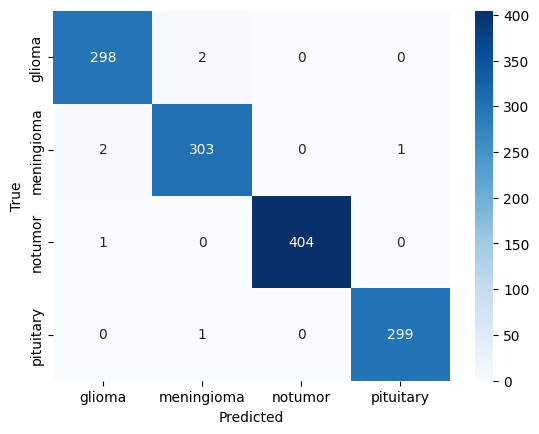

In [186]:
sns.heatmap(confusion_matrix(np.argmax(y_true_final, axis=1), np.argmax(y_pred_final, axis=1)),
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=df_train.columns.drop('path').to_list(),
            yticklabels=df_train.columns.drop('path').to_list())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The analysis of the Confusion Matrix visually confirms the model's exceptional accuracy, with almost all samples concentrated on the main diagonal. Out of a total of over $1,300$ test images, only $7$ errors were made overall.

Looking at the off-diagonal images, we note that the only significant uncertainties concern the reciprocal exchange between Glioma and Meningioma ($2$ cases each). This is expected and physiological behavior, as these two tumor types can exhibit similar morphological and texture characteristics in certain MRI scans. The classification of the No Tumor and Pituitary classes, however, is practically flawless, with virtually no errors, ensuring extremely high reliability in distinguishing healthy patients from those with disease.

Finally we offer a visualization of the $7$ misclassified images

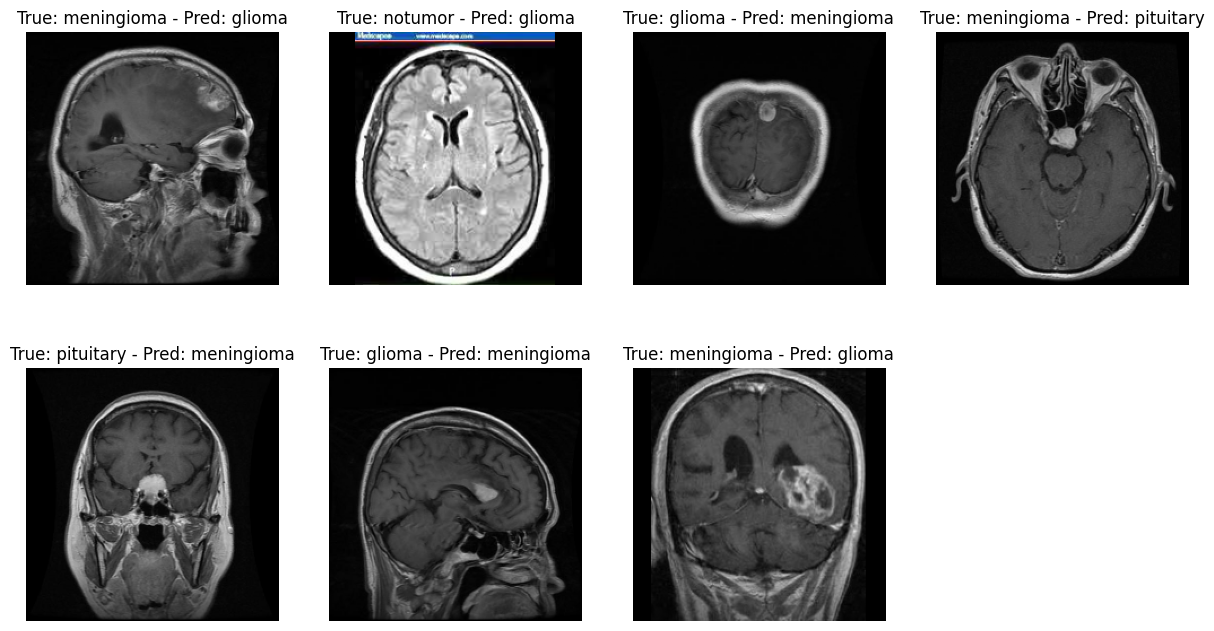

In [208]:
idx = []
y_true = np.argmax(y_true_final, axis=1)
y_pred = np.argmax(y_pred_final, axis=1)

for i in range(len(y_true)):
  if y_true[i] != y_pred[i]:
    idx.append(i)

test_images = np.concatenate([x for x, y in test_ds], axis=0)
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

plt.figure(figsize=(15, 8))

for i, target_index in enumerate(idx):
    ax = plt.subplot(int(len(idx)/4 + 1), 4, i + 1)
    img = test_images[target_index]
    label = test_labels[target_index]

    real_name = df_test.columns.drop('path')[y_true[idx[i]]]
    pred_name = df_test.columns.drop('path')[y_pred[idx[i]]]
    plt.title(f"True: {real_name} - Pred: {pred_name}")
    plt.axis("off")
    plt.imshow(img)

## 6. Conclusions

The work conducted in this notebook demonstrated how the use of advanced Transfer Learning techniques, applied to the Xception architecture, can lead to excellent results in the automatic classification of brain tumors from magnetic resonance images. The developed model achieved an accuracy of $99.5\%$ on the test set, with extremely stable behavior that ruled out overfitting, as evidenced by the near-perfect overlap between training and validation metrics.

In-depth error analysis using the confusion matrix revealed surgical precision in identifying healthy patients and pituitary tumor cases, reducing false negatives to zero in these critical categories. The only rare imperfections were limited to a minimal overlap between gliomas and meningiomas, a difficulty noted in the literature due to the morphological similarities these tumors can assume in certain scans.

Ultimately, the proposed system stands out as a valid clinical decision support (CAD) tool, capable of providing a rapid and reliable "second opinion" to the radiologist. For future developments, one could evaluate the integration of segmentation techniques to localize the tumor area in addition to classifying it, or the expansion of the dataset to include even rarer and more complex clinical cases.